In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from joblib import Parallel, delayed
from functools import partial

In [2]:
# constants
LEFT, RIGHT = -1, 1
NUM_STATES = 1000
STATES = np.arange(1, NUM_STATES + 1)
END_STATES = {0, NUM_STATES + 1}
STRIDE = 100

In [3]:
# aggregation value function wrapper
class Values:
    def __init__(self, groups):
        self.groups = groups
        self.group_size = NUM_STATES // groups
        self.thetas = np.zeros(groups)

    def value(self, state):
        if state in END_STATES: 
            return 0
        else: 
            return self.thetas[(state - 1) // self.group_size]
        
    def update(self, delta, state):
        self.thetas[(state - 1) // self.group_size] += delta

In [9]:
# random walk implementation
class MRP:
    def __init__(self, n=NUM_STATES):
        self.n = n
        self.start = (n + 1) // 2

    def reset(self):
        self.state = self.start
        return self.state

    def step(self):
        step = np.random.randint(1, STRIDE + 1)
        self.state += np.random.choice([LEFT * step, RIGHT * step])
        self.state = max(min(self.state, self.n + 1), 0)
        
        reward = 0.0
        if self.state in END_STATES: 
            reward = -1.0 if self.state == 0 else 1.0

        return self.state, reward

In [5]:
# semi-gradient td implementation
def semi_grad_td(mrp, V, n, alpha):
    state = mrp.reset()
    S, R = [state], [0]
    t, T = 0, float('inf')
    while True:
        if t < T:
            next_state, reward = mrp.step()
            S.append(next_state)
            R.append(reward)
            if next_state in END_STATES: T = t + 1
        tau = t - n + 1
        if tau >= 0:
            G = 0.0
            for i in range(tau + 1, min(tau + n, T) + 1):
                G += R[i]
            if tau + n < T:
                G += V.value(S[tau + n])
            if S[tau] not in END_STATES:
                delta = alpha * (G - V.value(S[tau]))
                V.update(delta, S[tau])
        if tau == T - 1:
            break
        t += 1
        state = next_state

In [7]:
# generate true values
V_TRUE = np.arange(-1001, 1003, 2) / 1001.0

error = float('inf')
while error > 1e-2:
    old = np.copy(V_TRUE)
    for state in STATES:
        V_TRUE[state] = 0
        for action in [LEFT, RIGHT]:
            for step in range(1, STRIDE + 1):
                step *= action
                next_state = state + step
                next_state = max(min(next_state, NUM_STATES + 1), 0)
                V_TRUE[state] += (1.0 / (STRIDE * 2)) * V_TRUE[next_state]
    error = np.sum(np.abs(old - V_TRUE))

V_TRUE[0] = V_TRUE[-1] = 0

In [10]:
# generate data for left figure
episodes = 100000
alpha = 2e-4
mrp = MRP(NUM_STATES)
V = Values(10)
for ep in tqdm(range(episodes)):
    semi_grad_td(mrp, V, 1, alpha)

approx_values = [V.value(i) for i in STATES]

100%|██████████| 100000/100000 [11:17<00:00, 147.64it/s]


In [11]:
# generate data for right figure
steps = np.power(2, np.arange(0, 10))
alphas = np.arange(0, 1.1, 0.1)
episodes = 10
runs = 100
errors = np.zeros((len(steps), len(alphas)))
mrp = MRP(NUM_STATES)
for run in tqdm(range(0, runs)):
    for n_i, n in enumerate(steps):
        for a_i, a in enumerate(alphas):
            V = Values(20)
            for ep in range(0, episodes):
                semi_grad_td(mrp, V, n, a)
                values = np.asarray([V.value(i) for i in STATES])
                errors[n_i, a_i] += np.sqrt(np.sum(np.power(values - V_TRUE[1: -1], 2)) / NUM_STATES)

errors /= episodes * runs

100%|██████████| 100/100 [16:29<00:00,  9.89s/it]


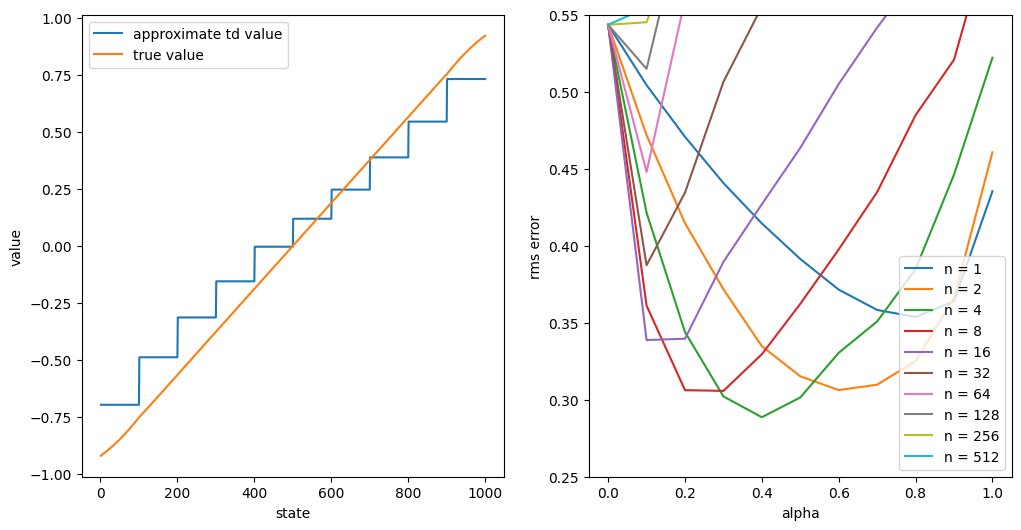

In [12]:
# generate figure
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(STATES, approx_values, label='approximate td value')
plt.plot(STATES, V_TRUE[1: -1], label='true value')
plt.xlabel('state')
plt.ylabel('value')
plt.legend()

plt.subplot(1, 2, 2)
for i, n in enumerate(steps):
    plt.plot(alphas, errors[i, :], label=f"n = {n}")
plt.xlabel('alpha')
plt.ylabel('rms error')
plt.ylim([0.25, 0.55])
plt.legend()

plt.show()